<a href="https://colab.research.google.com/github/SyedTazeem/machine-unlearning/blob/main/AIET_MUL_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn,optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

## Data Loading

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.49MB/s]


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

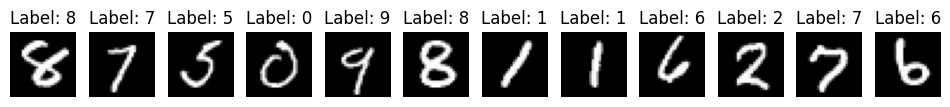

In [ ]:
fig, axes = plt.subplots(1,12, figsize=(12,2))
for i in range(12):
  ax = axes[i]
  ax.imshow(images[i].squeeze(), cmap='gray')
  ax.set_title(f'Label: {labels[i].item()}')
  ax.axis('off')
plt.show()

# Training the model

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
    self.pool = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
    self.gap = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(64, 10)
  def forward(self, x):
    x= self.pool(torch.relu(self.conv1(x)))
    x= self.pool(torch.relu(self.conv2(x)))
    x= self.gap(x)
    x= x.view(x.size(0), -1)
    x= self.fc(x)
    return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

In [ ]:
device

device(type='cuda')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for epoch in range(10):
  model.train()
  total_loss=0
  for imgs, y in train_loader:
    imgs, y = imgs.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(imgs)
    loss = criterion(y_pred, y)
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
  print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

Epoch 1, Loss: 0.5505538504362106
Epoch 2, Loss: 0.21520859953487914
Epoch 3, Loss: 0.17881055105676252
Epoch 4, Loss: 0.1550273806842665
Epoch 5, Loss: 0.14194472071938216
Epoch 6, Loss: 0.13593176723457873
Epoch 7, Loss: 0.1237578078025331
Epoch 8, Loss: 0.11642228858756522
Epoch 9, Loss: 0.11108797789532691
Epoch 10, Loss: 0.10751341838476558


In [ ]:
model.eval()
all_preds=[]
all_labels=[]
with torch.no_grad():
  for imgs, y in test_loader:
    imgs, y = imgs.to(device), y.to('cpu')
    y_pred = model(imgs).to('cpu')
    preds = yp.argmax(dim=1).numpy()
    all_preds.extend(preds)
    all_labels.extend(y.numpy())

all_preds=np.array(all_preds)
all_labels=np.array(all_labels)

In [ ]:
accuracy = (all_preds==all_labels).mean()
print(f'Accuracy: {accuracy}')

Accuracy: 0.9648


In [ ]:
print("\Classification Report:")
print(classification_report(all_labels, all_preds))

\Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.96      0.96      1032
           3       0.92      0.99      0.96      1010
           4       0.98      0.97      0.98       982
           5       0.95      0.95      0.95       892
           6       0.94      0.98      0.96       958
           7       0.99      0.95      0.97      1028
           8       0.98      0.94      0.96       974
           9       0.95      0.96      0.96      1009

    accuracy                           0.96     10000
   macro avg       0.97      0.96      0.96     10000
weighted avg       0.97      0.96      0.96     10000



In [ ]:
cm=confusion_matrix(all_labels, all_preds)

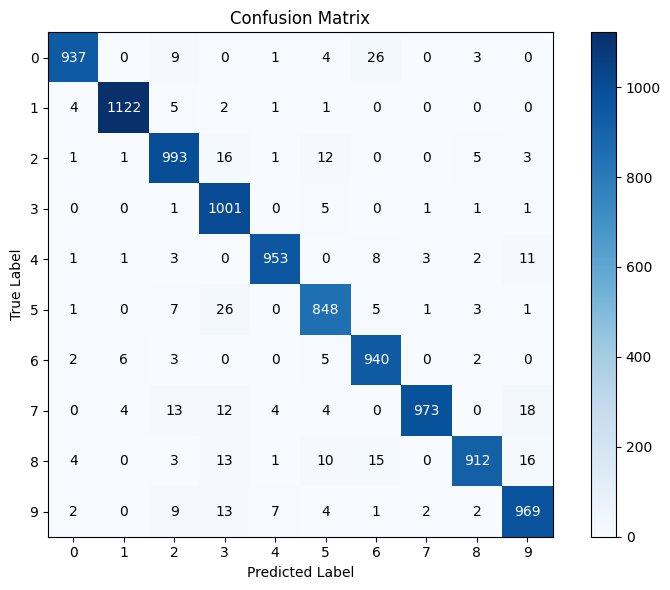

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.show()

thresh=cm.max()/2
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    plt.text(j, i, format(cm[i,j],'d'), ha='center', va="center", color='white' if cm[i,j]> thresh else 'black')
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'cnn_model.pth')
print("Model weights saved to CNN_model.pth")

Model weights saved to CNN_model.pth


# Gold Standard/ Retrained model

### Unlearn Class = 7

In [ ]:
# Filter out class “7”
removed_class = 7
train_mask = train_dataset.targets != removed_class
test_mask  = test_dataset.targets != removed_class

train_idxs = train_mask.nonzero().squeeze().tolist()
test_idxs  = test_mask.nonzero().squeeze().tolist()

subset_train = Subset(train_dataset, train_idxs)
subset_test  = Subset(test_dataset,  test_idxs)

In [ ]:
class RemapLabels(Dataset):
    def __init__(self, subset, removed_class):
        self.subset = subset
        self.removed = removed_class
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, i):
        img, lbl = self.subset[i]
        # If original lbl>removed_class, shift down by 1
        lbl = lbl - 1 if lbl > self.removed else lbl
        return img, lbl

In [ ]:
train_ds = RemapLabels(subset_train, removed_class)
test_ds  = RemapLabels(subset_test,  removed_class)

gold_train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
gold_test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

In [ ]:
class Gold_CNN(nn.Module):
  def __init__(self):
    super(Gold_CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
    self.pool = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
    self.gap = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(64, 9)
  def forward(self, x):
    x= self.pool(torch.relu(self.conv1(x)))
    x= self.pool(torch.relu(self.conv2(x)))
    x= self.gap(x)
    x= x.view(x.size(0), -1)
    x= self.fc(x)
    return x

In [ ]:
Gold_model = Gold_CNN().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Gold_model.parameters(), lr=0.001)

In [ ]:
for epoch in range(10):
  Gold_model.train()
  total_loss=0
  for imgs, y in gold_train_loader:
    imgs, y = imgs.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = Gold_model(imgs)
    loss = criterion(y_pred, y)
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
  print(f'Epoch {epoch+1}, Loss: {total_loss/len(gold_train_loader)}')

Epoch 1, Loss: 1.066743926491056
Epoch 2, Loss: 0.423215329926461
Epoch 3, Loss: 0.28569537648886795
Epoch 4, Loss: 0.22074435613273333
Epoch 5, Loss: 0.18382698745200676
Epoch 6, Loss: 0.16115650895628192
Epoch 7, Loss: 0.14564766315909636
Epoch 8, Loss: 0.13303008392297974
Epoch 9, Loss: 0.1250624021008012
Epoch 10, Loss: 0.11610683084748286


In [ ]:
Gold_model.eval()
all_preds=[]
all_labels=[]
with torch.no_grad():
  for imgs, y in gold_test_loader:
    imgs, y = imgs.to(device), y.to('cpu')
    y_pred = Gold_model(imgs).to('cpu')
    preds = y_pred.argmax(dim=1).numpy()
    all_preds.extend(preds)
    all_labels.extend(y.numpy())

all_preds=np.array(all_preds)
all_labels=np.array(all_labels)

In [ ]:
accuracy = (all_preds==all_labels).mean()
print(f'Accuracy: {accuracy}')

Accuracy: 0.9689032545697727


In [ ]:
print("\Classification Report:")
print(classification_report(all_labels, all_preds))

\Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       980
           1       0.99      0.98      0.99      1135
           2       0.97      0.96      0.96      1032
           3       0.96      0.99      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.96      0.97      0.96       892
           6       0.96      0.97      0.97       958
           7       0.98      0.94      0.96       974
           8       0.94      0.97      0.95      1009

    accuracy                           0.97      8972
   macro avg       0.97      0.97      0.97      8972
weighted avg       0.97      0.97      0.97      8972



In [ ]:
cm=confusion_matrix(all_labels, all_preds)

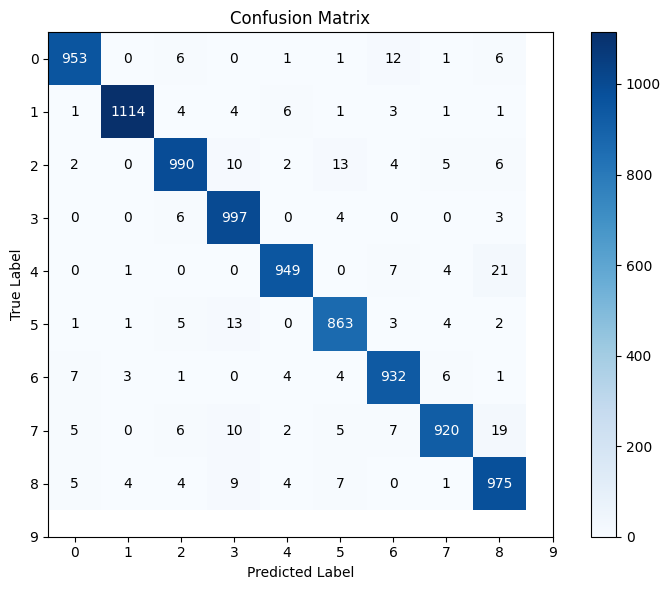

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

thresh=cm.max()/2
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    plt.text(j, i, format(cm[i,j],'d'), ha='center', va="center", color='white' if cm[i,j]> thresh else 'black')
plt.tight_layout()
plt.show()

## Unlearning Algorithm - Data Obfuscation

In [ ]:
import random
class7_idxs = (train_dataset.targets == 7).nonzero().squeeze().tolist()
selected_idxs = random.sample(class7_idxs, 200)

In [ ]:
labels_pool = list(range(10))
labels_pool.remove(7)
wrong_labels = [random.choice(labels_pool) for _ in selected_idxs]

In [ ]:
class Obfuscated7Dataset(Dataset):
    def __init__(self, base_dataset, indices, new_labels):
        self.base = base_dataset
        self.indices = indices
        self.new_labels = new_labels
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        img, _ = self.base[self.indices[i]]
        return img, self.new_labels[i]

In [ ]:
obf_ds = Obfuscated7Dataset(train_dataset, selected_idxs, wrong_labels)
obf_loader = DataLoader(obf_ds, batch_size=32, shuffle=True)

In [ ]:
model = CNN().to(device)
model.load_state_dict(torch.load('cnn_model.pth', map_location=device))

<All keys matched successfully>

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for imgs, labels in obf_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(obf_loader)
    print(f"Epoch {epoch}/{num_epochs} — Fine‑tune loss: {avg_loss:.4f}")

Epoch 1/20 — Fine‑tune loss: 11.0436
Epoch 2/20 — Fine‑tune loss: 9.2698
Epoch 3/20 — Fine‑tune loss: 8.6030
Epoch 4/20 — Fine‑tune loss: 7.0974
Epoch 5/20 — Fine‑tune loss: 6.2661
Epoch 6/20 — Fine‑tune loss: 5.7926
Epoch 7/20 — Fine‑tune loss: 5.3780
Epoch 8/20 — Fine‑tune loss: 4.8351
Epoch 9/20 — Fine‑tune loss: 4.6759
Epoch 10/20 — Fine‑tune loss: 4.4967
Epoch 11/20 — Fine‑tune loss: 4.2396
Epoch 12/20 — Fine‑tune loss: 4.0556
Epoch 13/20 — Fine‑tune loss: 4.1125
Epoch 14/20 — Fine‑tune loss: 3.7883
Epoch 15/20 — Fine‑tune loss: 3.6313
Epoch 16/20 — Fine‑tune loss: 3.7939
Epoch 17/20 — Fine‑tune loss: 3.6940
Epoch 18/20 — Fine‑tune loss: 3.6080
Epoch 19/20 — Fine‑tune loss: 3.5337
Epoch 20/20 — Fine‑tune loss: 3.5465


In [ ]:
model.eval()
all_preds=[]
all_labels=[]
with torch.no_grad():
  for imgs, y in test_loader:
    imgs, y = imgs.to(device), y.to('cpu')
    y_pred = model(imgs).to('cpu')
    preds = y_pred.argmax(dim=1).numpy()
    all_preds.extend(preds)
    all_labels.extend(y.numpy())

all_preds=np.array(all_preds)
all_labels=np.array(all_labels)

In [ ]:
accuracy = (all_preds==all_labels).mean()
print(f'Accuracy: {accuracy}')

Accuracy: 0.6412


In [ ]:
print("\Classification Report:")
print(classification_report(all_labels, all_preds))

\Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.24      0.34       980
           1       0.88      0.94      0.91      1135
           2       0.90      0.33      0.48      1032
           3       0.82      0.97      0.89      1010
           4       0.97      0.83      0.89       982
           5       0.72      0.71      0.71       892
           6       0.30      1.00      0.47       958
           7       1.00      0.04      0.08      1028
           8       0.70      0.87      0.78       974
           9       0.71      0.50      0.59      1009

    accuracy                           0.64     10000
   macro avg       0.76      0.64      0.61     10000
weighted avg       0.76      0.64      0.61     10000



In [ ]:
cm=confusion_matrix(all_labels, all_preds)

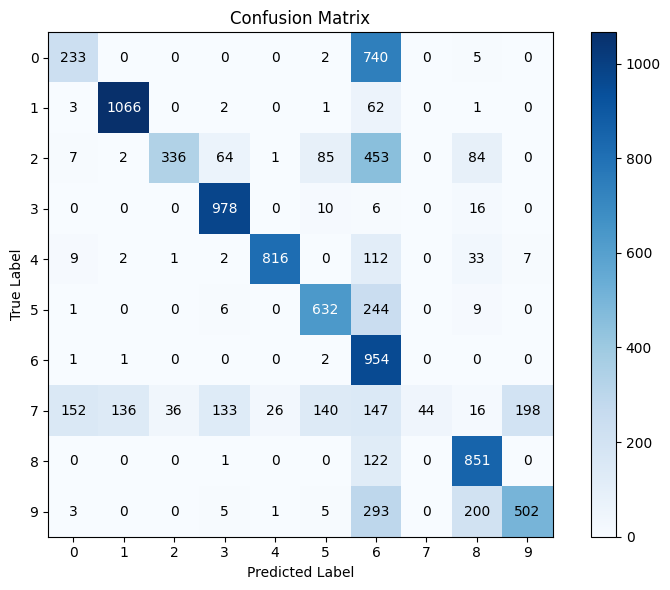

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.show()

thresh=cm.max()/2
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    plt.text(j, i, format(cm[i,j],'d'), ha='center', va="center", color='white' if cm[i,j]> thresh else 'black')
plt.tight_layout()
plt.show()

## Finetune this model on images of other classes

In [ ]:
other_class_idxs = (train_dataset.targets != 7).nonzero().squeeze().tolist()
selected_idxs = random.sample(other_class_idxs, 500)

In [ ]:
subset_otrain = Subset(train_dataset, selected_idxs)

In [ ]:
o_loader = DataLoader(subset_otrain, batch_size=32, shuffle=True)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for imgs, labels in o_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(o_loader)
    print(f"Epoch {epoch}/{num_epochs} — Fine‑tune loss: {avg_loss:.4f}")

Epoch 1/20 — Fine‑tune loss: 0.6004
Epoch 2/20 — Fine‑tune loss: 0.2696
Epoch 3/20 — Fine‑tune loss: 0.1558
Epoch 4/20 — Fine‑tune loss: 0.1142
Epoch 5/20 — Fine‑tune loss: 0.0948
Epoch 6/20 — Fine‑tune loss: 0.0848
Epoch 7/20 — Fine‑tune loss: 0.0828
Epoch 8/20 — Fine‑tune loss: 0.0726
Epoch 9/20 — Fine‑tune loss: 0.0677
Epoch 10/20 — Fine‑tune loss: 0.0664
Epoch 11/20 — Fine‑tune loss: 0.0621
Epoch 12/20 — Fine‑tune loss: 0.0581
Epoch 13/20 — Fine‑tune loss: 0.0573
Epoch 14/20 — Fine‑tune loss: 0.0535
Epoch 15/20 — Fine‑tune loss: 0.0509
Epoch 16/20 — Fine‑tune loss: 0.0484
Epoch 17/20 — Fine‑tune loss: 0.0476
Epoch 18/20 — Fine‑tune loss: 0.0449
Epoch 19/20 — Fine‑tune loss: 0.0450
Epoch 20/20 — Fine‑tune loss: 0.0413


In [ ]:
model.eval()
all_preds=[]
all_labels=[]
with torch.no_grad():
  for imgs, y in test_loader:
    imgs, y = imgs.to(device), y.to('cpu')
    y_pred = model(imgs).to('cpu')
    preds = y_pred.argmax(dim=1).numpy()
    all_preds.extend(preds)
    all_labels.extend(y.numpy())

all_preds=np.array(all_preds)
all_labels=np.array(all_labels)

In [ ]:
accuracy = (all_preds==all_labels).mean()
print(f'Accuracy: {accuracy}')

Accuracy: 0.8743


In [ ]:
print("\Classification Report:")
print(classification_report(all_labels, all_preds))

\Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       980
           1       0.89      1.00      0.94      1135
           2       0.91      0.95      0.93      1032
           3       0.94      0.98      0.96      1010
           4       0.84      0.99      0.91       982
           5       0.95      0.97      0.96       892
           6       0.98      0.97      0.97       958
           7       1.00      0.02      0.04      1028
           8       0.96      0.98      0.97       974
           9       0.61      0.94      0.74      1009

    accuracy                           0.87     10000
   macro avg       0.90      0.88      0.84     10000
weighted avg       0.90      0.87      0.83     10000



In [ ]:
cm=confusion_matrix(all_labels, all_preds)

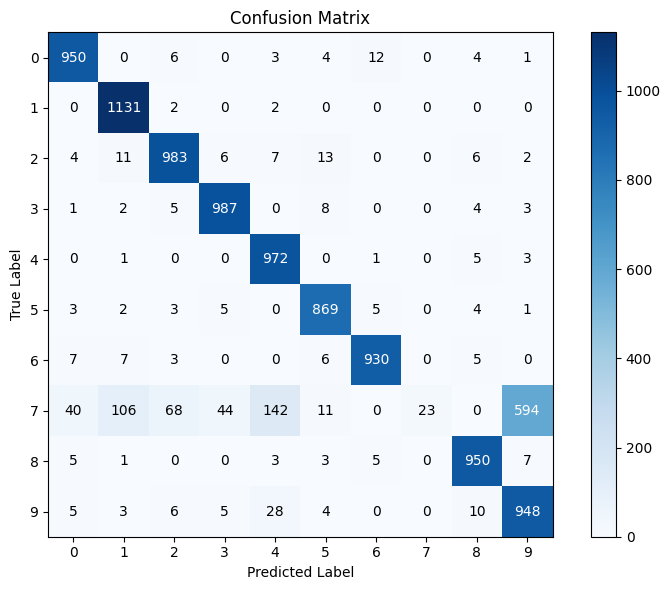

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.show()

thresh=cm.max()/2
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    plt.text(j, i, format(cm[i,j],'d'), ha='center', va="center", color='white' if cm[i,j]> thresh else 'black')
plt.tight_layout()
plt.show()